   ### Project: In this notebook we will use data science methodology to analyze an Open DataSet of Airbnb at Seattle from Kaggle

   #### our goal is to find out the performance of Airbnb business running in Seattle. In order to find out the result, we define three assumptions and let the data prove them.

1. Running an airbnb business will give substantial income
2. Do have methords for earning more.
3. Airbnb property price and revenue depends on some key features.

### Install Packages and Load Packages

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Import libraries for data processing and analyzing
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
# Import libraries for data visulization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for word processing
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def remove_unw2anted(str):
    '''
    Remove special characaters from one string
    '''
    str = ''.join([c for c in str if c in 'ABCDEFGHIJKLNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234567890\''])
    return str

def clean_sentence(s):
    '''
    Clean up sentence by removing unwanted special charaters word by word
    '''
    lst = [word for word in s.split()]

    lst_cleaned = []
    for items in lst:
        lst_cleaned.append(remove_unw2anted(items))
    return ' '.join(lst_cleaned)

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/roy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Open Data of Airbnb at Seattle
### Load Data

In [8]:
# there are three datasets needed to be imported For Seattle Airbnb Data
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

### View Data

1. calendar.csv with 11,393,570 rows of records, with some missing, we will handle these missing later
2. listings.csv with 3,818 rows of records and 93 columns (features), with some missing datas, some of them take high percentage in missing, we can just drop them, the others we will fill out with some mechanism.
3. reviews.csv has 84,849 records, with less missing records, will see if we still need them later.

In [9]:
display(calendar.info())
display(listings.info())
display(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


None

### Data Preprocessing

From the data we found that calendar.csv records 3,818 airbnb properties price along 2016. In order to solve the first assumptions, we need to explore this dataset, so let's clean up and preprocess this dataset first.

In [10]:
# Import calendar.csv and data preprocessing 


#Add a new column call full for indicating book status, 1 means booked, 0 means available,opposite from column 'available'
calendar['available'] = calendar['available'].astype(np.str)
calendar['full'] = calendar['available'].map(lambda x: 1 if x=='f' else 0)

# Change data type of price column and reassign to a new one called 'price_numeric'
calendar['price_numeric'] = calendar['price'].map(lambda x: str(x)[1:].replace(',','') if x is not np.nan else x).astype(np.float)
calendar['price_numeric'] = calendar.groupby(by='listing_id')['price_numeric'].apply(lambda x:x.fillna(x.mean()))
calendar.dropna(subset=['price_numeric'],inplace=True)

# Add a new column by multiplying price and book ratio (full)
calendar['revenue'] = calendar['price_numeric']*calendar['full']

### Data Exploratory

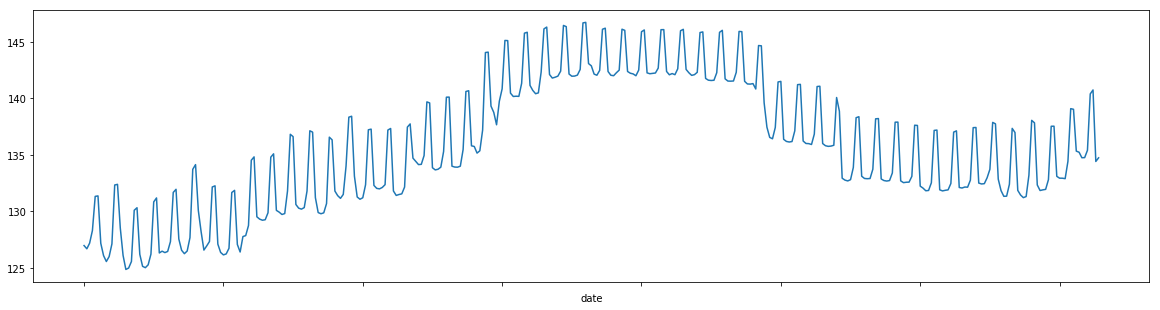

In [47]:
# Plot the average price along a year.
_,ax = plt.subplots(figsize=(20,5)) 
calendar.groupby(by='date').mean()['price_numeric'].plot(ax=ax)

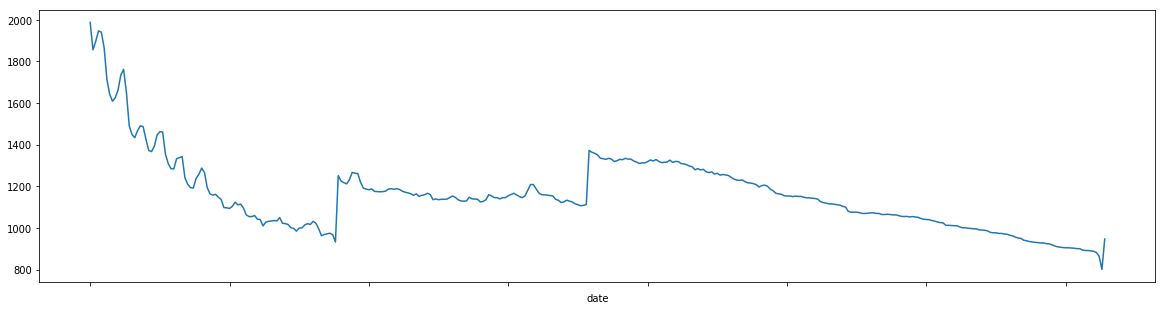

In [50]:
# Plot the book ratio along a year.
_,ax = plt.subplots(figsize=(20,5))
calendar.groupby(by='date').sum()['full'].plot(ax=ax)

### Assumption 1. Running an airbnb business will give substantial income

From the data description we can see that, the average revenue for running Airbnb is 14,927 yearly, the median is 6,311.76 yearly. We found that less than half properties can have this average amount.

,full,price_numeric,revenue
count,3723.000000,3723.000000,3723.000000
mean,113.981467,49553.881956,14927.165867
std,122.119707,35545.774008,20437.301296
min,0.000000,7300.000000,0.000000
25%,5.000000,27604.600507,473.415042
50%,52.000000,39571.879195,6311.764706
75%,226.000000,59166.292614,23600.000000
max,364.000000,475163.636364,188763.636364


1347 properties' revenue over average


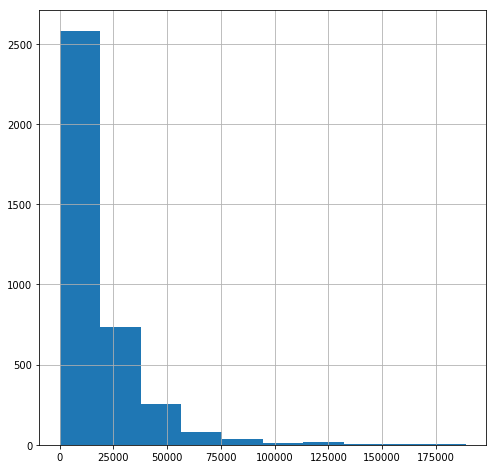

In [24]:
properties_revenue = calendar.groupby('listing_id').sum()
display(properties_revenue.describe())
properties_revenue['revenue'].hist(figsize=(8,8))
print len(properties_revenue[properties_revenue.revenue > properties_revenue.revenue.mean()]),'properties\' revenue over average'

From above figure and data statistic result, we can see that most of the properties' annual revenue fall in area where less than 25,000. The airbnb business in Seattle is not as good as we assumed.

### Assumption 2 Do have methords for earning more

### Some experiments with data

Let's use the top10 records for analysing

,full,price_numeric,revenue,avg
listing_id,,,,
3308979,145,475163.636364,188763.636364,1301.818182
6066570,329,198925.000000,179305.000000,545.000000
9497431,230,274866.629630,173203.629630,753.059259
10136155,320,175200.000000,153600.000000,480.000000
8036620,289,193161.842105,152941.842105,529.210526
9023202,316,163885.000000,141884.000000,449.000000
8942678,312,164250.000000,140400.000000,450.000000
9252998,327,146000.000000,130800.000000,400.000000
1747184,244,195259.917355,130529.917355,534.958678


Top 10 earn most


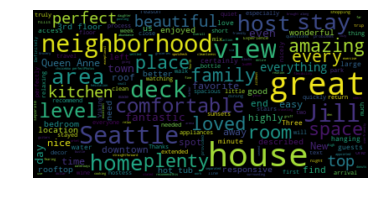

,word,counters
150,house,22
46,great,20
244,Jill,11
118,deck,10
23,neighborhood,10
22,Seattle,10
388,host,7
206,comfortable,7
401,area,7
67,would,6


Top 1 reviews word frequency


,id,reviews_per_month
2,3308979,1.15
22,8942678,0.86
356,5128160,0.79
432,1747184,1.29
1189,10136155,NaN
1298,9497431,NaN
2515,8036620,1.20
2906,9252998,NaN
3577,6066570,0.16
3618,9023202,NaN


Top 10 reviews per month


In [27]:
# find out the top revenue properties and check the reviews correlation

top_10_bnb = calendar.groupby('listing_id').sum().sort_values(by=['revenue'],ascending=False)[:10]
top_10_bnb_reviews = reviews[reviews.listing_id.isin(top_10_bnb.index.tolist())]
top_10_bnb_last_reviews = listings[listings.id.isin(top_10_bnb.index.tolist())][['id','reviews_per_month']]
reviews_words = reviews[reviews.listing_id.isin([top_10_bnb.index.tolist()[0]])]
top_10_bnb['avg'] = top_10_bnb['revenue']/top_10_bnb['full']
#display(reviews.groupby('reviewer_id').size().loc[reviews_words.reviewer_id.values])
display(top_10_bnb)
print "Top 10 earn most"
whole_words = []
for s in reviews_words['comments'].values:
    whole_words.append(''.join(clean_sentence(s)))

common_words=['I','The','us','We','stay']
stop = set(stopwords.words('english'))
stop.update(common_words)
words = [word for word in ''.join(whole_words).split() if word not in stop]
words_freq = Counter(words)
wordcloud = WordCloud(max_font_size=40).generate(''.join(whole_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
display(pd.DataFrame(list(words_freq.iteritems()),columns=['word','counters']).sort_values(by=['counters'],ascending=False)[:10])
print "Top 1 reviews word frequency"
display(top_10_bnb_last_reviews)
print "Top 10 reviews per month"
#calendar[calendar.listing_id.isin([top_10_bnb[1]])]['price_numeric'].hist()

Next we will check top 10 most reviews properties and their performance.

,listing_id,full,price_numeric,revenue,avg
554,53867,345,34529.000000,32637.000000,94.600000
1684,63308,91,35702.062044,8901.062044,97.813869
2006,365550,44,37514.267913,4522.267913,102.778816
2009,25002,57,28500.811688,4450.811688,78.084416
2154,5682,56,19689.919094,3020.919094,53.944984
2207,208356,25,37479.058824,2567.058824,102.682353
2393,92835,14,45867.293447,1759.293447,125.663818
2549,47196,17,24752.873563,1152.873563,67.816092
2884,841049,5,21170.000000,290.000000,58.000000
3013,279063,1,31226.552198,85.552198,85.552198


Top 10 most reviews properties performance


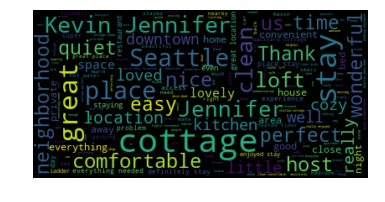

,word,counters
1093,cottage,216
1774,great,127
790,place,125
1780,Jennifer,105
1431,clean,103
612,Kevin,91
1747,Seattle,88
1003,It,81
73,would,79
1865,perfect,75


In [28]:
# Check the top 10 most reviews properties and their revenue

top_10_review_bnb=reviews.groupby('listing_id').size().sort_values(ascending=False)[:10]
top_10_review_last_reviews = listings[listings.id.isin(top_10_review_bnb.index.tolist())][['id','reviews_per_month']]
whole_words = []
for s in reviews[reviews.listing_id.isin([top_10_review_bnb.index.tolist()[8]])]['comments'].values:
    whole_words.append(''.join(clean_sentence(s)))

top_revenue_bnb = calendar.groupby('listing_id').sum().sort_values(by=['revenue'],ascending=False).reset_index()
top_revenue_bnb['avg'] = top_revenue_bnb['revenue']/top_revenue_bnb['full']
display(top_revenue_bnb[top_revenue_bnb['listing_id'].isin(top_10_review_bnb.index.tolist())])
print 'Top 10 most reviews properties performance'

common_words=['I','The','us','We','stay']
stop = set(stopwords.words('english'))
stop.update(common_words)
words = [word for word in ''.join(whole_words).split() if word not in stop]
words_freq = Counter(words)
wordcloud = WordCloud(max_font_size=40).generate(''.join(whole_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
display(pd.DataFrame(list(words_freq.iteritems()),columns=['word','counters']).sort_values(by=['counters'],ascending=False)[:10])

We can find out that the top most reviews properties, even they are mostly in porsitive position, but they don't have a good performance. So you can't get more revenue by encouraging more reviews in this case.

### Assumption 3 Airbnb property price and revenue depends on some key features

Let's preprocess the data that we have

In [87]:
# Preprocess function for categorical data

def clean_transform_category(df):
    '''
    This function is to fill out the missing category data with the most frequently appears data and transform them to Label
    '''
    new_df = df.copy()
    encoder = {}
    for col in new_df.select_dtypes(include=['object']).columns:
        new_df[col].fillna(new_df[col].mode()[0], inplace=True)
        encoder[col] = LabelEncoder()
        new_df[col] = encoder[col].fit_transform(new_df[col])
    
    return new_df,encoder

# Split out two kinds of data, digit and category, and transform category data to Label.
listing_join_available = listings.set_index('listing_id').merge(calendar.groupby('listing_id').sum(),left_index=True,right_index=True)
listing_join_available['price'] = listing_join_available['price'].map(lambda x: str(x)[1:].replace(',','') if x is not np.nan else x).astype(np.float)
listing_join_available_num = listing_join_available.select_dtypes(include=['int','float'])
listing_join_available_cat = listing_join_available.select_dtypes(include=['object'])
bool_cat_features = ['host_is_superhost','instant_bookable','require_guest_profile_picture',
                           'require_guest_phone_verification','host_has_profile_pic','host_identity_verified',
                           'is_location_exact','requires_license']
limited_cat_features = ['host_response_rate','property_type','room_type','bed_type','cancellation_policy']
cat_features = bool_cat_features+limited_cat_features
not_useful_num_features = ['scrape_id','host_id']
listing_join_available_num.drop(not_useful_num_features,axis=1,inplace=True)
listing_join_available_trans,encoder = clean_transform_category(listing_join_available[cat_features])
listing_join_available_clean = listing_join_available_num.join(listing_join_available_trans)

In [88]:
# clean up the data and preprocessing, if data missing over 50%, we will just drop these column, and if over 50% and we will process it base on its datatye
for column in listing_join_available_clean.columns:
    if listing_join_available_clean[column].count()/float(listing_join_available_clean.shape[0]) < 0.5:
        listing_join_available_clean.drop([column],axis=1,inplace=True)
    elif listing_join_available_clean[column].count()/float(listing_join_available_clean.shape[0]) < 1:
        # if the datatype is digit, we will fill it by median
        if column in listing_join_available_num.columns:
            listing_join_available_clean[column].fillna(listing_join_available_clean[column].median(),inplace=True)
        # if the dattype is category, we will fill the NA with mode.
        else:
            listing_join_available_clean[column].fillna(listing_join_available_clean[column].mode()[0],inplace=True)


(2978, 40)
(2978, 1)


/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train RMSE 19.92
Test RMSE 54.85


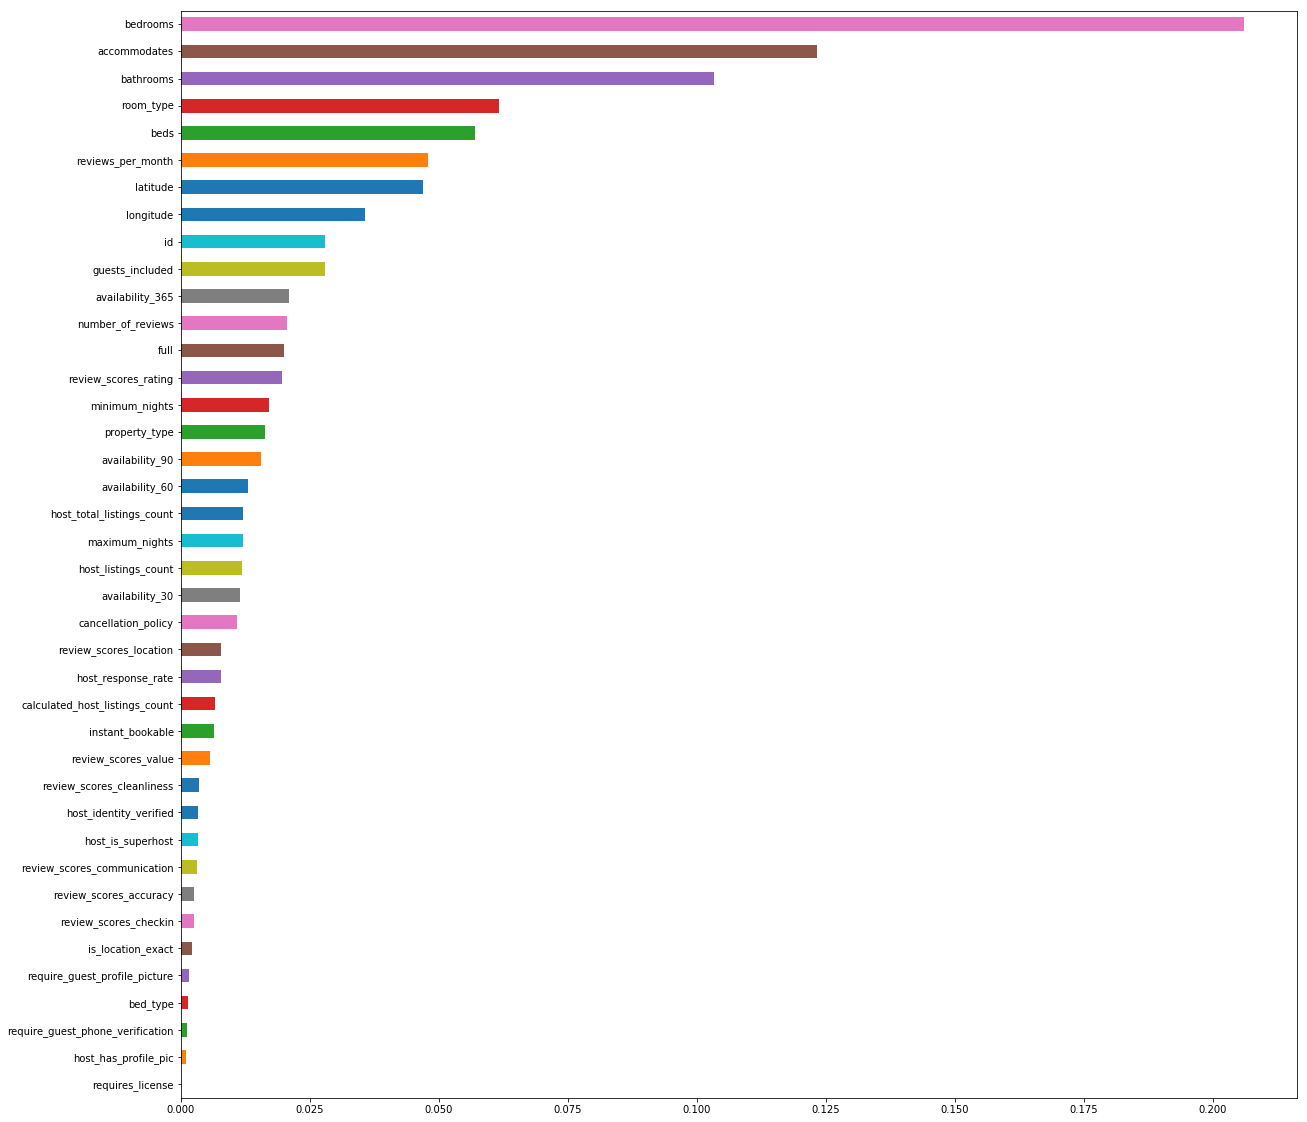

In [91]:
# Use RandomForestRegressor for predicting the price
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


train_listing_join_available_clean = listing_join_available_clean.dropna(subset=['price'])

X_train,X_test,y_train,y_test = train_test_split(train_listing_join_available_clean.drop(['price','price_numeric','revenue'],axis=1),train_listing_join_available_clean[['price']], test_size=0.2, random_state=42)


param_grid = [{'n_estimators':[200],'max_features':[15]}]
print X_train.shape
print y_train.shape

forest_reg = RandomForestRegressor(n_estimators=200,max_features=15,random_state=42)

#grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
model = forest_reg.fit(X_train,y_train)
#model = grid_search.best_estimator_
prediction = model.predict(X_test)
tree_mse = mean_squared_error(y_test,prediction)
tree_rmse = np.sqrt(tree_mse)

train_prediction = model.predict(X_train)
train_tree_rmse = np.sqrt(mean_squared_error(y_train,train_prediction))
print "Train RMSE %.2f" % train_tree_rmse
print "Test RMSE %.2f" % tree_rmse

#print grid_search.best_params_

feature_importance = {}
for name,score in zip(X_train.columns,model.feature_importances_):
    feature_importance[name]=score

pd.Series(feature_importance).sort_values().plot(kind='barh',figsize=(20,20))

From above figure we can notice that the most importance key feature for dermining price is the bedrooms and accomodates, that means the basic feature for a property is critical for dermining the price.

#### Further we check and distribution of the property type

x, ['Apartment' 'Bed & Breakfast' 'Boat' 'Bungalow' 'Cabin' 'Camper/RV'
 'Chalet' 'Condominium' 'Dorm' 'House' 'Loft' 'Other' 'Tent' 'Townhouse'
 'Treehouse' 'Yurt']
hue, ['Entire home/apt' 'Private room' 'Shared room']


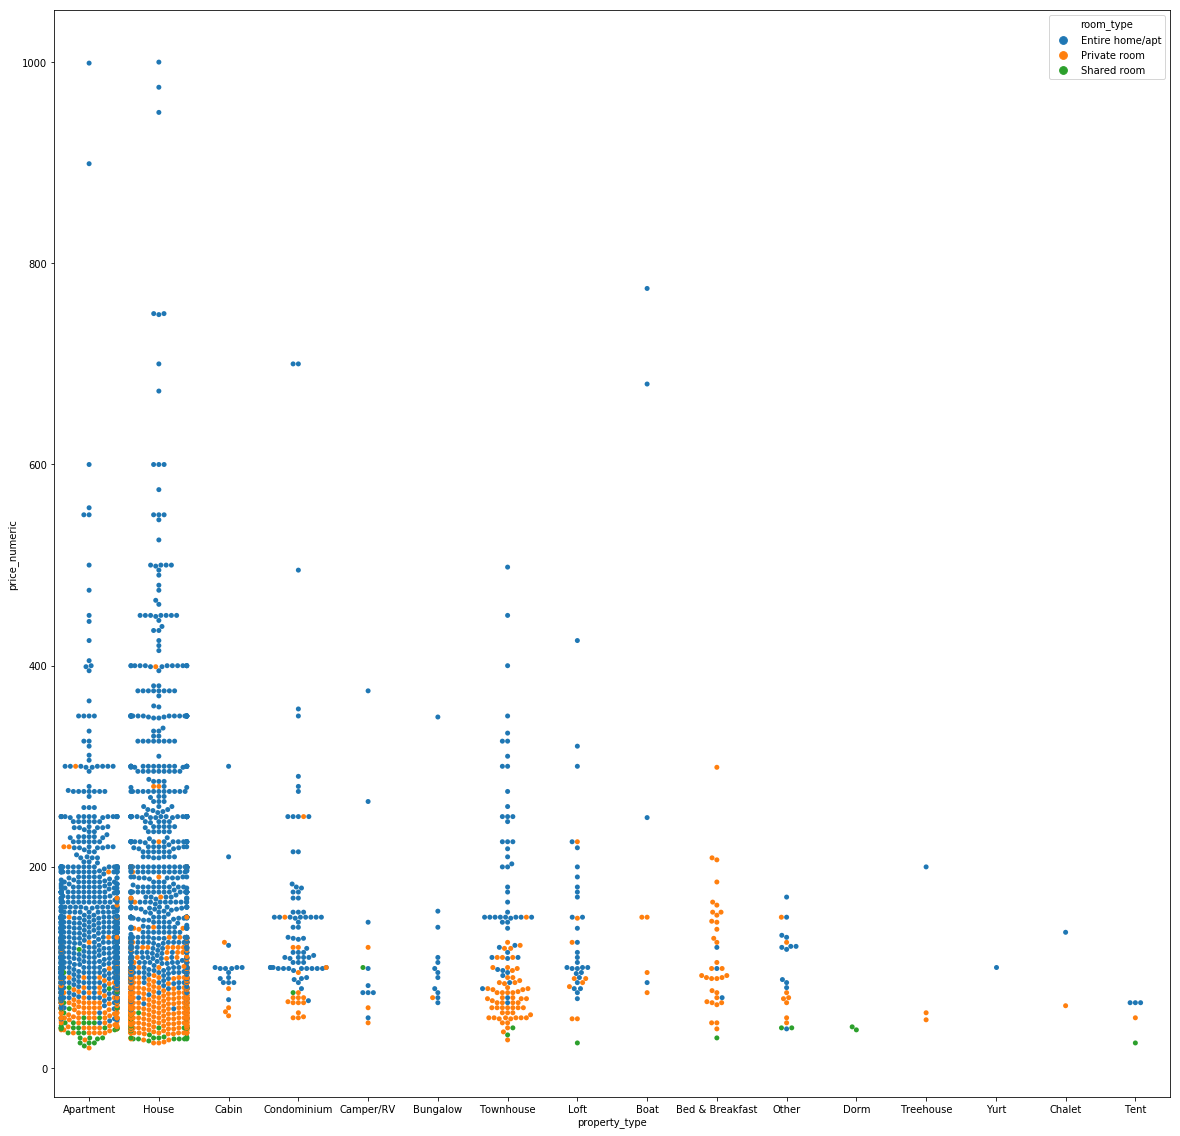

In [676]:
# Plot price distribution base on room type and property type
print 'x, %s' % encoder['property_type'].classes_
print 'hue, %s' % encoder['room_type'].classes_
listings['price_numeric'] = listings['price'].str.replace("[$, ]", "").astype("float")
_ , ax = plt.subplots( figsize =( 20 , 20 ) )
sns.swarmplot(x="property_type", y="price_numeric",hue='room_type', data=listings,ax=ax,);

From the figure we can find that majority of the room type is Apartment and House, and also they are charging higher than others, when entire home/apt is more than other types, which makes sense.

#### Next we try to get further to find out what are important in predicting the revenue for running the Airbnb business.

(2978, 36)
(2978, 1)


/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/sklearn

Train RMSE 5.69
Test RMSE 3.32


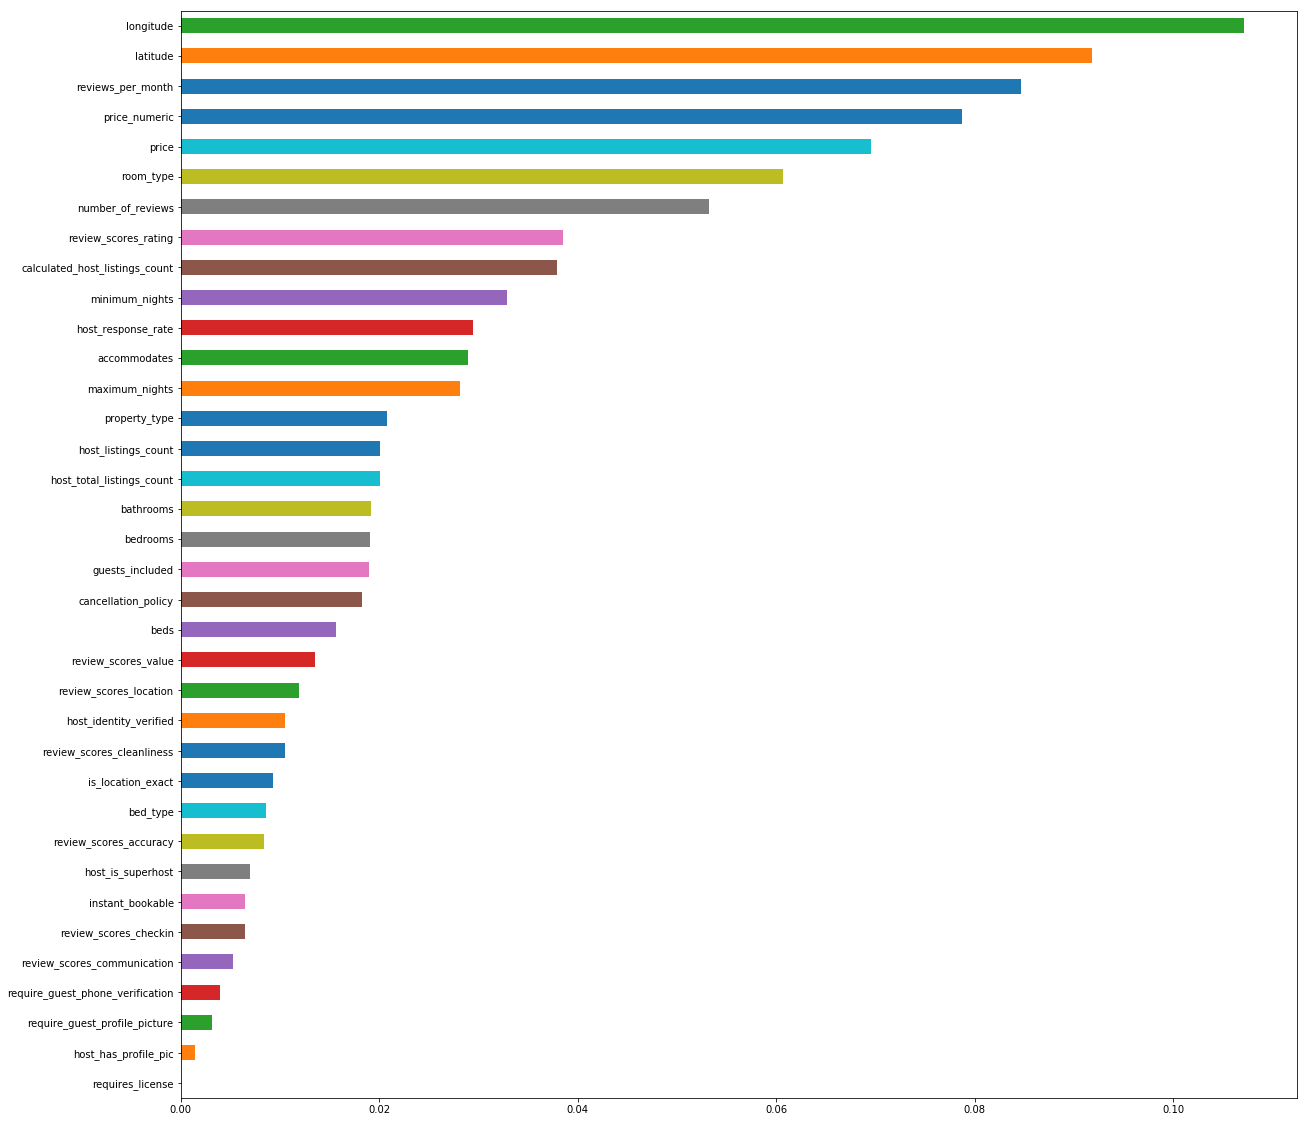

In [94]:
# Predict the revenue by using RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV



listing_join_available_clean_revenue = listing_join_available_clean.dropna(subset=['revenue']).drop(['id'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(listing_join_available_clean_revenue.drop(['revenue','availability_365','availability_90','availability_60','availability_30','full'],axis=1),np.log1p(listing_join_available_clean_revenue[['revenue']]), test_size=0.2, random_state=42)


param_grid = [{'n_estimators':[400]}]
print X_train.shape
print y_train.shape

#forest_reg = RandomForestRegressor(n_estimators=200,max_features=15,random_state=42)

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train,y_train)
model = grid_search.best_estimator_
prediction = model.predict(X_test)
tree_mse = mean_squared_error(y_test,prediction)
tree_rmse = np.sqrt(tree_mse)

train_prediction = model.predict(X_train)
train_tree_rmse = np.sqrt(mean_squared_error(np.log1p(y_train),train_prediction))
print "Train RMSE %.2f" % train_tree_rmse
print "Test RMSE %.2f" % tree_rmse

#print grid_search.best_params_

feature_importance = {}
for name,score in zip(X_train.columns,model.feature_importances_):
    feature_importance[name]=score

pd.Series(feature_importance).sort_values().plot(kind='barh',figsize=(20,20))

From above figure we can find that the key features for dertermining the revenue are location, reviews_per_month and price. Let do further calrify by getting their correlation with revenue as following

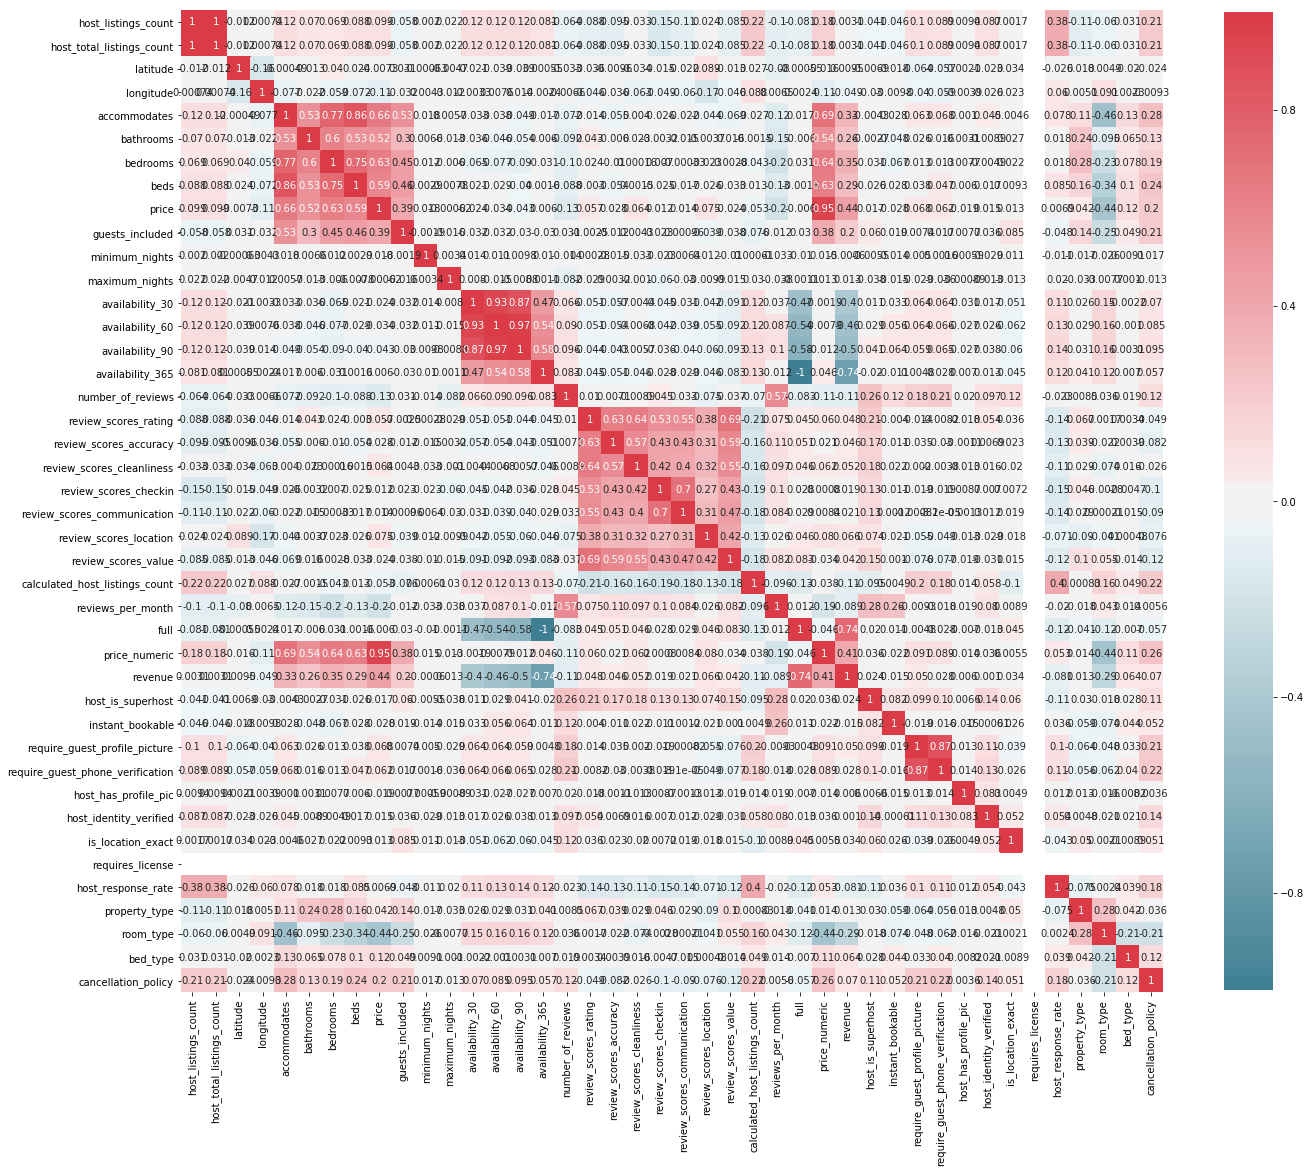

In [95]:
# Draw correlation graph for each other features
_ , ax = plt.subplots( figsize =( 22 , 20 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
        listing_join_available_clean_revenue.select_dtypes(include=['int','float']).corr(), 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
    )

From the correlation figure we can find out that, the room features take positive effects on the revenue while reviews_per_month takes negative effect on the revenue, which I think it's interesting findings.

### Conclusion

Looking back to our three assumptions at the beginning

1. Running an airbnb business will give substantial income

   As shown by data, we don't think running an airebunb business in Seattle can have subsgtantial income.
   
2. Do have methords for earning more.

   As shown by data, no clear factors for making a property generates more income than others, but it's own property features, like size, accomodates etc.
   
3. Airbnb property price and revenue depends on some key features.

   Yes, they are property features and reviews number per month